In [1]:
from sklearn.linear_model import SGDRegressor
import pandas as pd
import joblib
import numpy as np
import random

In [2]:
np.random.seed(42)
random.seed(42)

In [3]:
def read_merge_data(data_type="training"):
    #
    Dfs = []
    train_df = []
    train_output = pd.read_csv("./data_phase_one/training_output.csv", header=None)
    coords = pd.read_csv("data_phase_one/coords.csv", header=None)
    for name in ["mslp", "sst", "ssta", "t2m"]:
        df = pd.read_csv(f"./data_phase_one/{data_type}_input_{name}.csv", header=None)
        print("Shape df", df.shape)
        Dfs.append(df)
    j = 0
    for i in range(0, df.shape[0]-12, 1):
        feat = pd.concat([coords, Dfs[0].iloc[i:i+12], Dfs[1].iloc[i:i+12], Dfs[2].iloc[i:i+12], Dfs[3].iloc[i:i+12]], axis=0).reset_index(drop=True)
        tgt = train_output.iloc[i+11]
        tgt = tgt.T.reset_index(drop=True)
        feat = feat.T.reset_index(drop=True)
        feat = pd.concat([feat, tgt], axis=1)
        assert feat.shape[1]==51
        feat.columns = [f"feat_{k}" for k in range(feat.shape[1]-1)] + ["target"]
        if j < 3:
            print(feat.columns)
        train_df.append(feat)
        j += 1
    train_df = pd.concat(train_df, axis=0)
    #Dfs.index = [f"col_{i}" for i in range(848)]
    return train_df

In [4]:
data = read_merge_data()

Shape df (849, 5774)
Shape df (849, 5774)
Shape df (849, 5774)
Shape df (849, 5774)
Index(['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6',
       'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23', 'feat_24',
       'feat_25', 'feat_26', 'feat_27', 'feat_28', 'feat_29', 'feat_30',
       'feat_31', 'feat_32', 'feat_33', 'feat_34', 'feat_35', 'feat_36',
       'feat_37', 'feat_38', 'feat_39', 'feat_40', 'feat_41', 'feat_42',
       'feat_43', 'feat_44', 'feat_45', 'feat_46', 'feat_47', 'feat_48',
       'feat_49', 'target'],
      dtype='object')
Index(['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6',
       'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23'

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

In [15]:
def normalize_data(X_train, X_val):
    Scaler = StandardScaler()
    data1 = Scaler.fit_transform(X_train)
    data2 = Scaler.fit_transform(X_val)
    return data1, data2

In [6]:
cv = KFold(n_splits=5, shuffle=True)

In [83]:
params_sgd = {
    "verbose": 1,
    #"alpha": 0.0001,
    "max_iter": 10000,
    #"learning_rate": 0.01,
    "warm_start": True
    }

In [84]:
for state, (train_idx, val_idx) in enumerate(cv.split(data)):
    X_train = data.drop(columns=["target"]).iloc[train_idx].values
    X_val = data.drop(columns=["target"]).iloc[val_idx].values
    y_train = data["target"].iloc[train_idx].values
    y_val = data["target"].iloc[val_idx].values
    X_train, X_val = normalize_data(X_train, X_val)
    print(f"\nTrain: {len(y_train)}, Val: {len(y_val)}\n")
    sgd_model = SGDRegressor(**params_sgd, random_state=state)
    sgd_model.fit(X_train, y_train)
    joblib.dump(sgd_model, f"./kfold_trained/sgd_model_fold{state}.joblib")


Train: 3866270, Val: 966568

-- Epoch 1
Norm: 0.43, NNZs: 50, Bias: -0.117040, T: 3866270, Avg. loss: 0.149977
Total training time: 1.39 seconds.
-- Epoch 2
Norm: 0.47, NNZs: 50, Bias: -0.106615, T: 7732540, Avg. loss: 0.149547
Total training time: 3.38 seconds.
-- Epoch 3
Norm: 0.48, NNZs: 50, Bias: -0.110029, T: 11598810, Avg. loss: 0.149440
Total training time: 4.47 seconds.
-- Epoch 4
Norm: 0.50, NNZs: 50, Bias: -0.115914, T: 15465080, Avg. loss: 0.149383
Total training time: 5.54 seconds.
-- Epoch 5
Norm: 0.52, NNZs: 50, Bias: -0.114566, T: 19331350, Avg. loss: 0.149335
Total training time: 6.63 seconds.
-- Epoch 6
Norm: 0.53, NNZs: 50, Bias: -0.118121, T: 23197620, Avg. loss: 0.149298
Total training time: 7.69 seconds.
Convergence after 6 epochs took 7.70 seconds

Train: 3866270, Val: 966568

-- Epoch 1
Norm: 0.44, NNZs: 50, Bias: -0.116473, T: 3866270, Avg. loss: 0.149948
Total training time: 2.07 seconds.
-- Epoch 2
Norm: 0.46, NNZs: 50, Bias: -0.113492, T: 7732540, Avg. loss:

In [85]:
n = 200

In [86]:
pred_sgd = sgd_model.predict(X_val[:n])

In [87]:
print("sgd error:", np.linalg.norm(y_val[:n]-pred_sgd))

sgd error: 5.464192206027521


In [68]:
import matplotlib.pyplot as plt

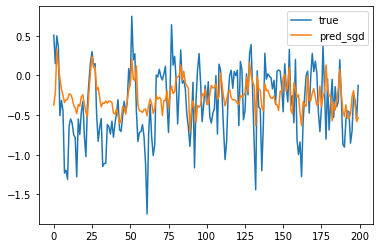

In [89]:
plt.plot(y_val[:n])
plt.plot(pred_sgd)
plt.legend(["true", "pred_sgd",])
plt.show()